# Skin Cancer Classification

### Import Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import PIL.Image as img
from keras.layers import Dense, Conv2D , MaxPool2D , Dropout , Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import os
from glob import glob
import math
from imblearn import over_sampling, under_sampling
from IPython.display import display
import skimage

# REMINDER:
Any visualizations, modifications, or changes must be done with the dataframe named "copy_data"! The "copy_data" dataframe is created in the bottom cell under the header "Merge Datasets". The mod_data dataframe is set up with a delicate and specific structure that cannot be changed -- copy_data is an exact clone that you may feel free to use, split, and separate with carte blanche.

#### Personal Notes:

Our next steps involve k-fold CV as a regulation technique, as well as data augmentation for strong generalizing power. I'll need to look at hyperparameter tuning in the near future as well. As an aside, here are what each number in the "label" column corresponds to:
```
0: nv - Melanocytic nevi
1: mel - Melanoma
2: bkl - Benign keratosis-like lesions
3: bcc - Basal cell carcinoma
4: akiec - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
5: vasc - Vascular lesions
6: df - Dermatofibroma
```
The abbreviations are given in the original metadata under the "dx" column; I make these diagnoses clearer in the modified dataset.

We also need to split along proportion in the training and testing sets -- it wouldn't do to have differing class representations in each. Similarly, we ought to downsample #4. 

## Read in Dataset

In [2]:
data = pd.read_csv("./data/hmnist_28_28_L.csv")
metadata = pd.read_csv("./data/HAM10000_metadata.csv")

# Normalize data:
#data_normalized = data / 255

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


We normalize the dataset because we want to get a value as a *percentage* of brightness, rather than a specific luma key. I've done some analysis on this to know that we don't have any issues, as would be expected for a dataset cultivated for machine learning rather than "real-world" data. I'll likely do more to figure out what kind of distributions exist across cancer type, gender, cancer location, etc. For now though, let's do the fun stuff!

## Metadata Analysis

In [3]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Good to know! It looks like we've got 57 cases whose age was not recorded. This is a low enough number that I feel comfy replacing these missing ages with the mean age across the whole dataset. I'm using imputation rather than removal because I want to use as much available data as possible. 

In [4]:
# Fill na values "age" variable
metadata["age"].fillna(metadata["age"].mean(), inplace = True)
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [5]:
# Check work with .describe:
metadata["age"].describe()

count    10015.000000
mean        51.863828
std         16.920252
min          0.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

Interesting... we have some cases where the recorded age is zero!! It's unlikely (I think, at least; I'm not really an expert in pediatric oncology) to have a patient who is truly less than a year old in for skin cancer, so I'm going to assume that these cases are simply a mixup in data entry -- some unknown ages were input as NA, some unknown ages were input as 0. Let's fix that too.

#### First, let's check how many 0s we have....

In [6]:
metadata["age"].value_counts()[0]

39

Well that's okay, only 39 zeros! I wanted to check and make sure -- it's always nasty if they make up some absurd number like 1/2 the dataset!

In [7]:
metadata["age"] = metadata["age"].replace(0, metadata["age"].mean())
metadata["age"].describe()

count    10015.000000
mean        52.065794
std         16.606576
min          5.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

In [8]:
data.groupby("label").count()["pixel0001"]

label
0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
Name: pixel0001, dtype: int64

This data is weighted funny... we'll need to make sure that we find a way around this statistically; too many actinic keratoses cases may skew our predictive capacity. There's got to be a way around it, but I'll check with Cheng on Thursday after class.

Note: Found the solution! I need to come up with a way to select proportionally, or maybe I'll do it with class weights. It might be a little unorthodox to do for a majority column, but we'll give it a go.  

## Merge datasets

I want to make sure that I can keep all data contained in the same dataframe so we can perform a more detailed analysis. I've decided to provide specific names for each skin lesion abbreviation to make my visualizations clearer, and included the image path in the dataframe to make it simpler to find and plot images. I add the label column because each skin lesion is associated with a numeric label code in the pre-built image arrays. In the event I want to use one of these other datasets, I want the switch to be as smooth as possible. Moreover, I will need to one-hot encode the label column to use it in a CNN like I intend to, and readability is helped by making similar changes all at the same time.

In [9]:
# Create lesion type dataset:

cancer_types_dict = {
    "akiec" : "Actinic Keratoses",
    "bcc" : "Basal Cell Carcinoma",
    "bkl" : "Benign Keratosis-like Lesions",
    "df" : "Dermatofibroma",
    "mel" : "Melanoma",
    "nv" : "Melanocytic Nevi",
    "vasc" : "Vascular Lesions"
}

# Create dict of img paths:
base_skin_set = os.getcwd() # this should work for everybody, so long as the file is in the "data" folder!

image_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_set, '*', '*.jpg'))} # This is modified stack-overflow code, but it works!

In [10]:
# Create modified dataframe:
mod_data = metadata

mod_data["Cell_Type"] = mod_data['dx'].map(cancer_types_dict.get)
mod_data["Path"] = mod_data["image_id"].map(image_id_path_dict.get)
mod_data["Label"] = pd.Categorical(mod_data['Cell_Type']).codes # Aligns data labels with .csv files in original download
mod_data.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,Cell_Type,Path,Label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2


In [11]:
# Check for NA values in "Path"
print(mod_data[mod_data["Path"].isna()])

# Create Copy Data
copy_data = mod_data # This is the dataframe you'll want to be using!!

Empty DataFrame
Columns: [lesion_id, image_id, dx, dx_type, age, sex, localization, Cell_Type, Path, Label]
Index: []


### Plot Images From Modified Data
We'll want to groupby the type of cancer so we can display the entirity of available specimens instead of benign keratosis-like lesions alone. 

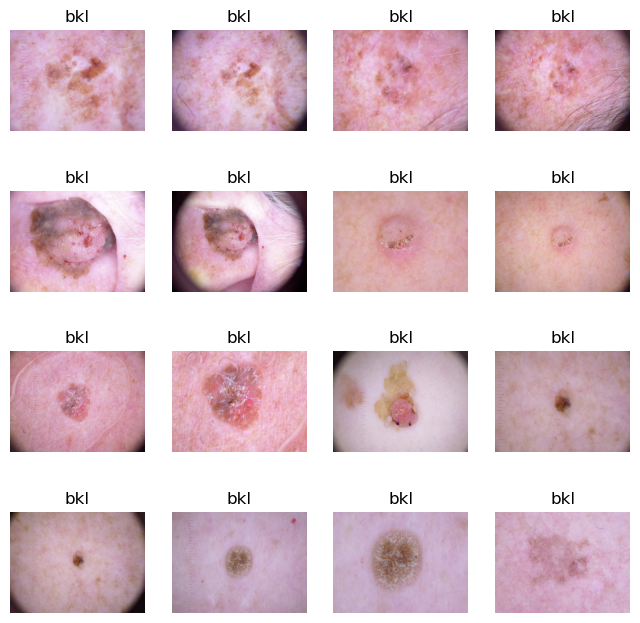

In [12]:
plt.figure(figsize = (8,8))

for i in range(16):
    plt.subplot(4,4, i + 1)
    x = plt.imread(mod_data.Path[i])
    plt.axis("off")
    plt.title(mod_data.dx[i])
    plt.imshow(x)

In [13]:
# Let's check our incoming image size:
image = img.open(mod_data["Path"][0]) # I use 1 because the 0th index of "Path" is in  X_test
print(f"Image Size: {image.size}")

Image Size: (600, 450)


Good to know -- this is likely to be to big to be efficient given our limitations. We'll need to resize.

In [14]:
# Split into Train and Test sets
Train_dataframe, Test_dataframe = train_test_split(mod_data, test_size = .3, stratify = mod_data["Label"])

display(print(np.unique(Train_dataframe["dx"])), print(np.unique(Test_dataframe["dx"])))

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


None

None

We've found that we need to ensure proportional representaion of all classes in the training and testing set to prevent the CNN from going crazy and returning awful performance on the evaluation. Thus, we pre-split the data into training and testing sets, stratifying along the "Label" category. The stratify parameter is ensuring that the random split of this dataset has the same proportions of class labels as the input dataset -- if we have 75% "1" and 25% "0", the train and test datasets will have 75% "1" and 25% "0" in each dataframe. This is good for what we need, which is making sure that we are showing the model everything it'll encounter in the testing set. 

In [15]:
# Define Preprocessing Function

### Note to Self: Add Edge detection, Vignette detection / cropping. 

def preprocess(input_image):
  image1 = input_image
  grey = greyscale(image1)
  contrast = apply_contrast(grey)
  blurred = blur(contrast)
  threshold = skimage.filters.threshold_mean(blurred)
  mask = blurred < threshold
  image1[~mask] = 0
  return image1

def greyscale(image):
  image = skimage.color.rgb2gray(image)
  #for clr in range(image.shape[2]):
  #  image[:,:,clr]=image.mean(axis=2)
  return image

def apply_contrast(image):
  percentiles = np.percentile(image, (0.5, 99.5))
  # array([ 1., 28.])
  #image_dark = skimage.exposure.adjust_gamma(image, gamma=1.5,gain=1)
  image_bright = skimage.exposure.adjust_gamma(image, gamma=0.5,gain=1)
  scaled = skimage.exposure.rescale_intensity(image_bright,
                                    in_range=tuple(percentiles))
  return scaled

def blur(image):
  blurred_image = skimage.filters.gaussian(image, sigma=1.0)
  return blurred_image


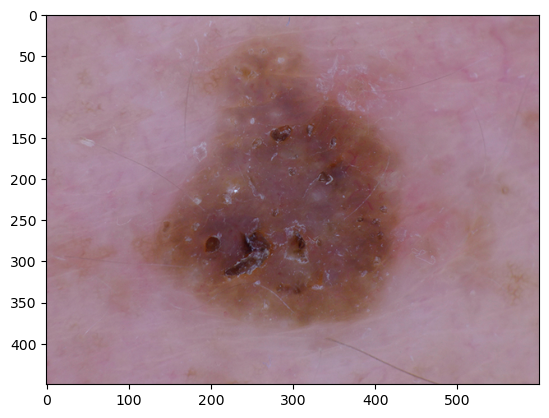

In [16]:
x = np.array(plt.imread(mod_data.Path[100]))
ximage = img.fromarray(x)
display(plt.imshow(ximage))


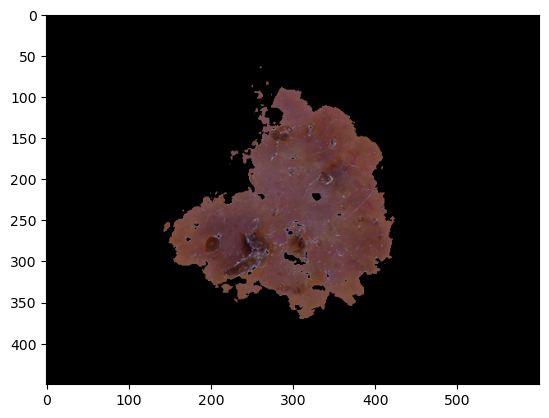

In [17]:
x = np.array(plt.imread(mod_data.Path[100]))
ximage = img.fromarray(x)
y = preprocess(x)
yimage = img.fromarray(y)
#color_img = cv2.cvtColor(y, cv2.COLOR_GRAY2RGB) 
plt.imshow(yimage)

I'll explain this on tuesday -- but it's essentially just some extra feature selection

### Flow From Dataframe

In [18]:
# Flow From Dataframe
from keras.preprocessing.image import ImageDataGenerator

# Create Train Generator 
train_gen = ImageDataGenerator(rescale = 1.0 / 255, preprocessing_function = preprocess)

# Create Test Generator
test_gen = ImageDataGenerator(rescale = 1.0 / 255, preprocessing_function = preprocess)

# Training
x_gen = train_gen.flow_from_dataframe(dataframe = Train_dataframe, x_col = "Path", y_col = "dx", target_size = (128, 128), batch_size = 32,
                                class_mode = "categorical", shuffle = True, seed = 1729)
# Testing
y_gen = test_gen.flow_from_dataframe(dataframe = Test_dataframe, x_col = "Path", y_col = "dx", target_size = (128, 128), batch_size = 32,
                                class_mode = "categorical", seed = 1729)

Found 7010 validated image filenames belonging to 7 classes.
Found 3005 validated image filenames belonging to 7 classes.


This code draws from the dataframe "mod_data", selecting the image path as the variable and dx as the label, one-hot enocoding the label in the process. The image is reshaped to (128, 128) and normalized so values are between 0 & 1. The validation split is 70-30; I intend to draw from a harvard repository of similar skin cancer images as a final testing set. This draws the images in a more memory efficient manner than the .map(lambda: x ...) stratagem I employed earlier. This less efficent method is commented out below, but kept for the sake of preservation.

### Over and UnderSampling Data


So, here's where we stand. Right now, we've got all the data fixed up and in a position where we can start building a model, but there's still a problem here. We have massive class imbalances in this dataset; Melanocytic Nevi makes up more than HALF of our samples! Ergo, we're going to test over and undersampling out to see how they look

In [19]:
# This block of code oversamples the data
"""
# Define number of classes
CLASSES = len(np.unique(mod_data["Cell_Type"]))

# Individual class probabilities in dataset
display(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))

# Ideal uniform class probability
display(print("Ideal Uniform:"), 1 / CLASSES)

# Resample data to even class probabilies
oversample = over_sampling.RandomOverSampler()
mod_data, mod_data["Label"] = oversample.fit_resample(mod_data, mod_data["Label"])

# Display Resampled Probs.
display(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))
"""

'\n# Define number of classes\nCLASSES = len(np.unique(mod_data["Cell_Type"]))\n\n# Individual class probabilities in dataset\ndisplay(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n\n# Ideal uniform class probability\ndisplay(print("Ideal Uniform:"), 1 / CLASSES)\n\n# Resample data to even class probabilies\noversample = over_sampling.RandomOverSampler()\nmod_data, mod_data["Label"] = oversample.fit_resample(mod_data, mod_data["Label"])\n\n# Display Resampled Probs.\ndisplay(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n'

Okay, so here's where we're at. The above block of code functions as it is meant to, however, it produces a LOT of extra data. A LOT. We jump from 10,015 data points to 46,935!! That's a pretty nasty amount of data to work with, and is forcing me to reconsider how we approach our runtime issues. At the moment, I'm thinking that we try an undersampling technique, and see where that gets us. 

In [20]:
# This block of code undersamples the data
"""
CLASSES = len(np.unique(mod_data["Cell_Type"]))

# Individual class probabilities in dataset
display(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))

undersampler  = under_sampling.RandomUnderSampler()

mod_data, mod_data["Label"] = undersampler.fit_resample(mod_data, mod_data["Label"])

# Display Resampled Probs.
display(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))
"""

'\nCLASSES = len(np.unique(mod_data["Cell_Type"]))\n\n# Individual class probabilities in dataset\ndisplay(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n\nundersampler  = under_sampling.RandomUnderSampler()\n\nmod_data, mod_data["Label"] = undersampler.fit_resample(mod_data, mod_data["Label"])\n\n# Display Resampled Probs.\ndisplay(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n'

Undersampling the data, on the other hand, limits us to 805 datapoints; not nearly enough to train any kind of robust model. This is where I start to think about class weights -- which is given just a few modules down. 

### Class Weight Adjustments

There's a couple of things I'll need to clean up here. First, I'm setting the class weights to "balanced", which uses the following formula to calculate weight:
\begin{equation*}
\frac{n_{samples}}{n_{classes} \cdot \operatorname{bincount}(y)}
\end{equation*}
This is great, but I need to find the actual likelihood of each of these cancers -- if one is super rare it clearly doesn't need to be represented with equal weight! Similarly if another is super common. 

In [21]:
# Set Class Weights
class_weights = np.around(class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(mod_data["Label"]), y = mod_data["Label"]))

# Zip to dict indexed by label
class_weights = dict(zip(np.unique(mod_data["Label"]), class_weights))
print(class_weights)

{0: 4.0, 1: 3.0, 2: 1.0, 3: 12.0, 4: 0.0, 5: 1.0, 6: 10.0}


In [22]:
# Compute Class Weights and Store in Dict

labelcount = {}
labels = np.unique(mod_data["Label"])

for label in labels:
    x = math.log(((1 / np.count_nonzero(mod_data["Label"] == label)) * (len(mod_data) / 2)))
    labelcount[label] = x #if x >= 1.0 else 1.0

labelcount


{0: 2.72873189664272,
 1: 2.2764688020848083,
 2: 1.516536113136352,
 3: 3.773759939176723,
 4: -0.29191672817580555,
 5: 1.5038777162644286,
 6: 3.5628650099387125}

### Model Architecture

In [23]:
"""
input_shape = (128, 128, 3)
num_classes = 7

model = models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
"""

"\ninput_shape = (128, 128, 3)\nnum_classes = 7\n\nmodel = models.Sequential()\nmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))\nmodel.add(MaxPool2D(pool_size = (2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))\nmodel.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))\nmodel.add(MaxPool2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.40))\n\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(num_classes, activation='softmax'))\nmodel.summary()\n"

In [24]:
"""
model = models.Sequential()
        

model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (128, 128, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="valid"))
model.add(tf.keras.layers.BatchNormalization())


model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())


model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten()) 

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              
model.add(Dense(7, activation = 'softmax'))
model.summary()
"""

'\nmodel = models.Sequential()\n        \n\nmodel.add(Conv2D(filters = 96,\n                kernel_size = (11, 11),\n                strides = (4, 4),\n                activation = \'relu\',\n                input_shape = (128, 128, 3)))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))\n\n\nmodel.add(Conv2D(filters = 256,\n                kernel_size=(5, 5),\n                strides=(1, 1),\n                activation = \'relu\',\n                padding = "same"))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))\n\n\nmodel.add(Conv2D(filters = 384,\n                 kernel_size=(3,3),\n                 strides=(1,1),\n                 activation=\'relu\',\n                 padding="valid"))\nmodel.add(tf.keras.layers.BatchNormalization())\n\n\nmodel.add(Conv2D(filters = 384,\n                kernel_size = (1, 1), \n                strides = (1, 1), \n                

In [25]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import plot_model

# Instantiate Class Inception (yes, like the movie)

class Inception(tf.keras.Model):
    # Channel refers to the specific output channel for each branch; please note that channels 2 & 3 must be given as tuples.
    def __init__(self, channel1, channel2, channel3, channel4):
        super().__init__() 
        self.branch1_1 = tf.keras.layers.Conv2D(channel1, 1, activation = "relu") # Note that we add a 1x1 convolution
        self.branch2_1 = tf.keras.layers.Conv2D(channel2[0], 1, activation = "relu")
        self.branch2_2 = tf.keras.layers.Conv2D(channel2[1], 3, activation = "relu", padding = "same")
        self.branch3_1 = tf.keras.layers.Conv2D(channel3[0], 1, activation = "relu")
        self.branch3_2 = tf.keras.layers.Conv2D(channel3[1], 5, activation = "relu", padding = "same")
        self.branch4_1 = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 1, padding = "same")
        self.branch4_2 = tf.keras.layers.Conv2D(channel4, kernel_size = 1, activation = "relu")
        
    def call(self, x):
        branch1 = self.branch1_1(x)
        branch2 = self.branch2_2(self.branch2_1(x))
        branch3 = self.branch3_2(self.branch3_1(x))
        branch4 = self.branch4_2(self.branch4_1(x))
        output = tf.keras.layers.Concatenate()([branch1, branch2, branch3, branch4])
        return output
            
            
            
            

An inception block consists of 4 parallel branches. The first three, as shown above, consist of kernels in shapes [1x1; 3x3; 5x5], which OUGHT to do a good job deriving high-level information from different spatial dimensions. It may behoove us to experiment with slightly larger kernel sizes in combination with higher channel sizes. The middle two branches incorporate a 1x1 convolution to reduce computational expense further, following Szegedy, et. al. Finally, these outputs are concatonated along channel and comprise the block's output. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4160      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 192)      0         
 2D)                                                             
                                                                 
 inception (Inception)       (None, 16, 16, 256)       1

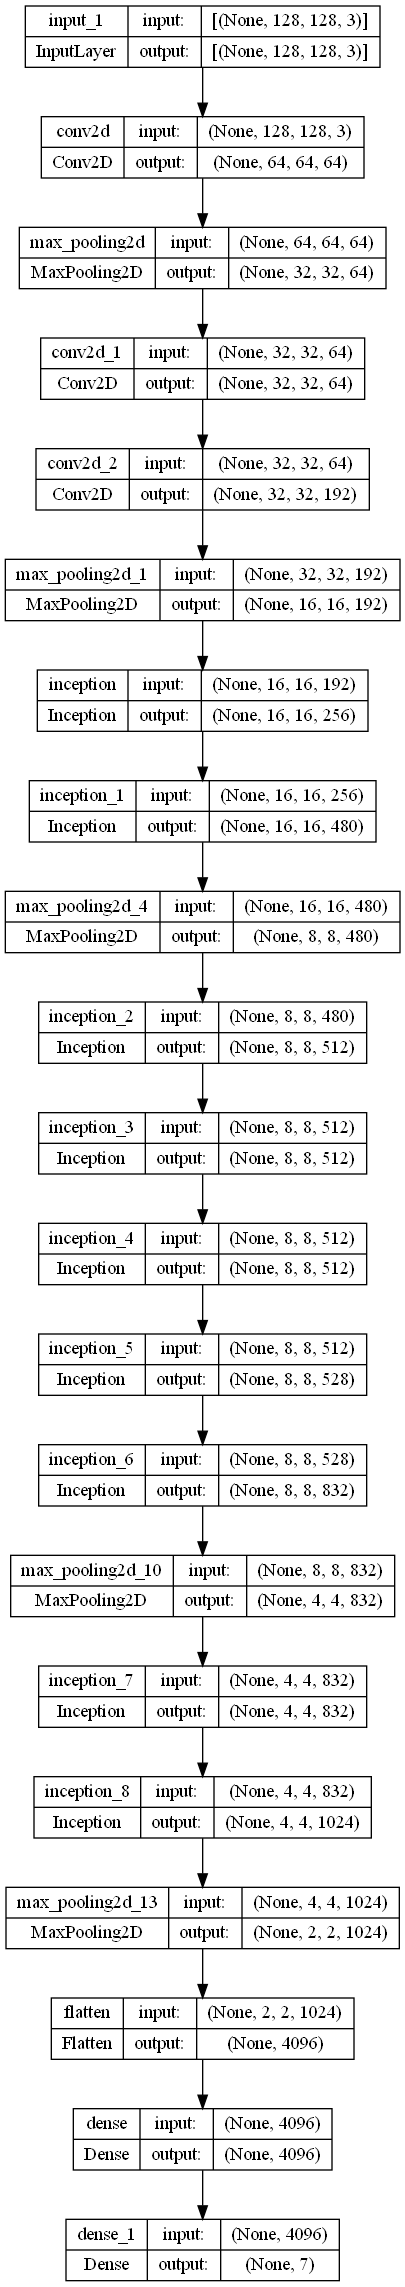

In [26]:
model = models.Sequential()

# Block One
model.add(tf.keras.layers.Input(shape = (128, 128, 3)))
model.add(Conv2D(64, kernel_size = 7, strides = 2, activation = "relu", padding = "same")) # 7x7, with kernel overlap
model.add(MaxPooling2D(pool_size = 3, strides = 2, padding = "same"))

# Block Two
model.add(Conv2D(64, kernel_size = 1, activation = "relu"))
model.add(Conv2D(192, kernel_size = 3, activation = "relu", padding = "same")) # 3x3 kernel; triples channels
model.add(MaxPooling2D(pool_size = 3, strides = 2, padding = "same"))

# Block Three
model.add(Inception(64, (92, 128), (16, 32), 32))
model.add(Inception(128, (128, 192), (32, 96), 64))
model.add(MaxPooling2D(pool_size=3, strides=2, padding= "same"))

# Block Four
model.add(Inception(192, (96, 208), (16, 48), 64))
model.add(Inception(160, (112, 224), (24, 64), 64))
model.add(Inception(128, (128, 256), (24, 64), 64))
model.add(Inception(112, (144, 288), (32, 64), 64))
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(MaxPooling2D(3, 2, padding = "same"))

# Block Five
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(Inception(384, (192, 384), (48, 128), 128))
model.add((MaxPooling2D()))
model.add(tf.keras.layers.Flatten())
model.add(Dense(4096, activation = "relu"))
model.add(Dense(7, activation = "softmax"))
model.summary()
keras.utils.plot_model(model, show_shapes = True)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=2,
    mode='min',
    restore_best_weights=True)

In [28]:
optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(x_gen, epochs = epochs, callbacks = [early_stopping], class_weight = labelcount)

Epoch 1/15
 18/220 [=>............................] - ETA: 14:24 - loss: 2.7697 - accuracy: 0.6111

I need to make some changes to this structure -- right now, it'll take an estimated 88.15 minutes to train this NN. That ain't gonna work, sooooo let's try playing with some other stuff. 

In [ ]:
# This code is being held in stasis for the moment...
"""
labelcount = {}
labels = np.unique(copy1["Label"])

for label in labels:
    labelcount[label] = np.count_nonzero(copy1["Label"] == label)

max = np.max(list(labelcount.values()))
for x in labels:
    change = max - labelcount[x]
    temp_df = copy1.iloc[np.random.choice(np.where(copy1["Label"] == x)[0], size = change)]
    data_df = copy1.append(temp_df, ignore_index = True)

copy1 = copy1.sample(frac = 1).reset_index(drop = True)
"""

C:\Users\new owner\AppData\Local\Temp\ipykernel_1100\161257170.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = copy1.append(temp_df, ignore_index = True)


<AxesSubplot: >

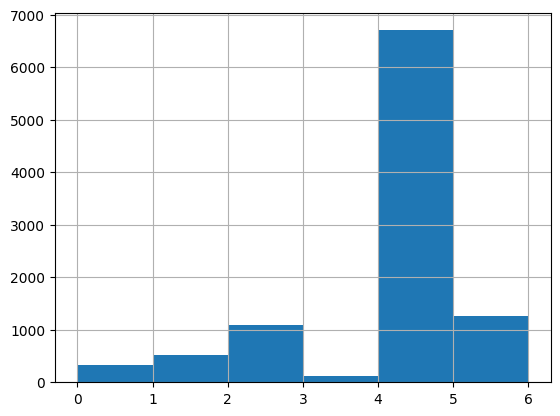

In [ ]:
copy1["Label"].hist(bins = np.unique(copy1["Label"]))